<a href="https://colab.research.google.com/github/dancher00/Experimental-Data-Analysis/blob/main/determining_and_removing_drawback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import shift

np.random.seed(42)

# Assignment 3. Determining and removing drawback of exponential and running mean.

Team 1:

-Alexey Kotcov: coded first part of the assignment, reviwed second part.

-Roman Khalikov: reviewed all code and plots, made conclusions and improved report style.

-Danil Belov: coded second part, made plots, reviewed first part.

## Part 1. Backward exponential smoothing

1. Forward exponential smoothing from assignment 2 part 2.

In [ ]:
# exponential smoothing for the measurements
def exponential_mean(z, alpha, way='forward'):
    if way not in ['forward', 'backward', 'both']:
        raise Exception('Choose proper way of exponential smoothing')
    smoothed = np.zeros(len(z))
    if way == 'forward' or way == 'both':
        smoothed[0] = z[0]
        for i in range(1,len(z)):
            smoothed[i] = smoothed[i-1] + alpha * (z[i] - smoothed[i-1])
    if way == 'backward' or way == 'both':
        if way == 'backward':
            smoothed = z
        for i in range(len(z)-2,0,-1):
            smoothed[i] = smoothed[i+1] + alpha * (smoothed[i] - smoothed[i+1])
    return smoothed

# Universal running mean function which accepts numpy array and appropriate window size
def running_mean(z, window_size):
    if not window_size%2 or not window_size > 1:
        raise Exception('Window size must be odd and > 1')
    result = np.zeros_like(z)
    interval = int((window_size-1)/2)
    for i in range(-interval,interval+1):
        result = result + shift(z, i)/window_size
    return result

In [ ]:
# trajectory noise variance
sigma_w = 28**2
size_of_trajectory = 300
true_trajectory = np.zeros(size_of_trajectory)
# Normally distributed random noise with zero mathematical expectation and variance sigma_w
noise = np.random.normal(0, np.sqrt(sigma_w), size_of_trajectory-1)
# Initial condition X_1
true_trajectory[0] = 10
# Random walk model
for i in range(1,size_of_trajectory):
    true_trajectory[i] = true_trajectory[i-1] + noise[i-1]

 # measurement noise variance
sigma_eta = 97**2
# Normally distributed random noise with zero mathematical expectation and variance sigma_eta
measurement_noise = np.random.normal(0, np.sqrt(sigma_eta), size_of_trajectory)
# Measurements generation
measurement = true_trajectory + measurement_noise

# Exponential mean optimal coeffitient
chi = sigma_w/sigma_eta
alpha = (-chi + np.sqrt(chi**2+4*chi))*0.5

# Running mean optimal window size
sigma_rm = sigma_es = sigma_eta*alpha/(2-alpha)
M = int(np.round(sigma_eta/sigma_rm))
''
forward_exponential_smoothing = exponential_mean(measurement, alpha)
mean_smoothing = running_mean(measurement,M)

2. Backward exponential smoothing applying

In [ ]:
backward_exponential_smoothing = exponential_mean(forward_exponential_smoothing, alpha, way='backward')

3. Visual comparison and deviation, variability indicators calculation

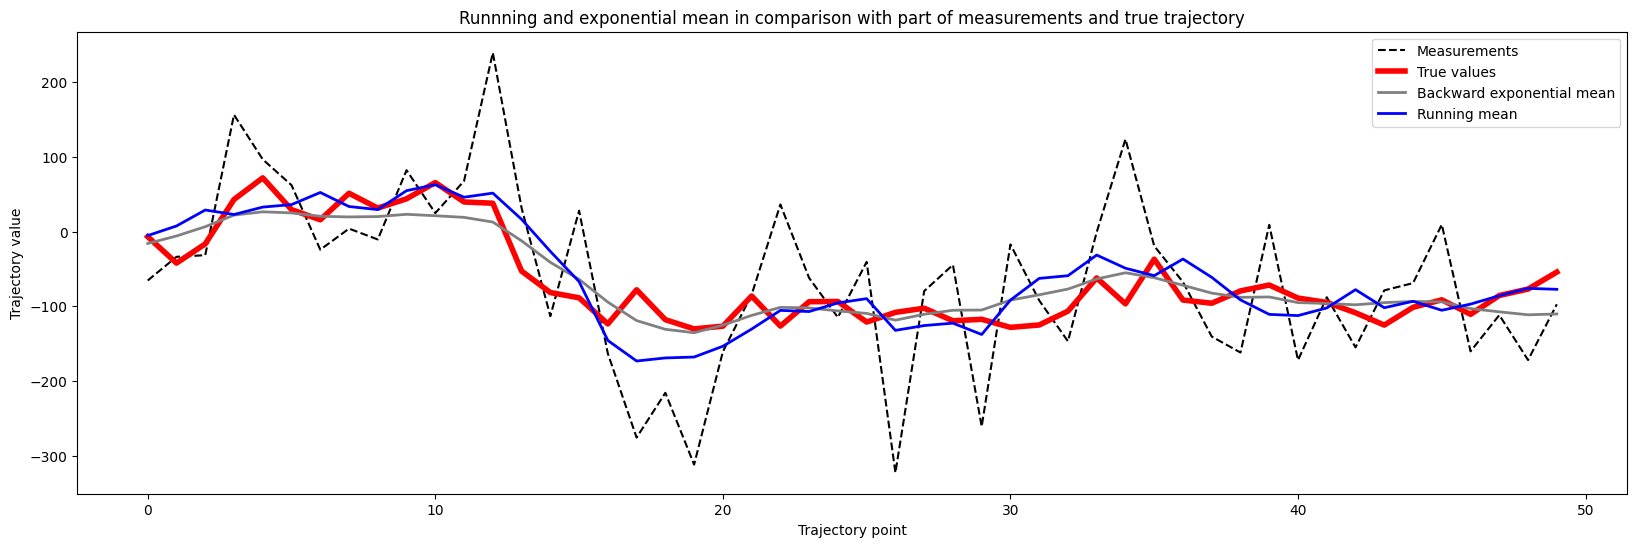

In [ ]:
plt.figure(figsize=(20, 6))
# To visually analyze the effect of smoothing, lets take only small part of data
plt.title('Runnning and exponential mean in comparison with part of measurements and true trajectory')
plt.plot(measurement[250:], '--', color = 'black', label = 'Measurements')
plt.plot(true_trajectory[250:], label = 'True values', c='red', linewidth=4)
plt.plot(backward_exponential_smoothing[250:], label = 'Backward exponential mean', c = 'gray', linewidth=2)
plt.plot(mean_smoothing[250:], label = 'Running mean', c = 'blue', linewidth=2)
plt.ylabel('Trajectory value')
plt.xlabel('Trajectory point')
plt.legend()


Now the exponential mean is much closer to the true values than it was previously. It is a best estimator according to the plot. Let's compare them numerically:

In [ ]:
# Metrics to check the performance of approximation
def deviation_indicator(z, x):
    return ((z-x)**2).sum()
def variability_indicator(x):
    return ((shift(x, -2)[:-2] - 2 * shift(x, -1)[:-2] + x[:-2])**2).sum()

print(f'Deviation indicator for running mean = {deviation_indicator(measurement, mean_smoothing)}; backward exponential mean = {deviation_indicator(measurement, backward_exponential_smoothing)}')
print(f'Variability indicator for running mean = {variability_indicator(mean_smoothing)}; backward exponential mean = {variability_indicator(backward_exponential_smoothing)}')

Deviation indicator for running mean = 2240561.1911267685; backward exponential mean = 2221784.4276307663
Variability indicator for running mean = 207379.19362242275; backward exponential mean = 15740.586048026737


As we can see, the backward exponential mean is better. It is smoother and at the same time closer to the measurements.

## Part 2. Drawback of running mean

1. Generate a true trajectory X_i of an object motion disturbed by normally distributed random
acceleration

In [ ]:
size_of_trajectory = 300

X = np.zeros(size_of_trajectory)
V = np.zeros(size_of_trajectory)

X[0] = 5
V[0] = 0
T = 0.1


sigma_a = 10

noise_a = np.random.normal(0, np.sqrt(sigma_a), size_of_trajectory-1)

for i in range(1,size_of_trajectory):
    V[i] = V[i-1] + noise_a[i-1]*T
    X[i] = X[i-1] + V[i-1]*T + (noise_a[i-1]*T**2)/2

Measurements of the process generation

In [ ]:
sigma_eta = 500
measurement_noise = np.random.normal(0, np.sqrt(sigma_eta), size_of_trajectory)

z = X + measurement_noise

We can notice that the line itself is pretty linear and we have very noisy measurements

2. Empirical window size and smoothing coeffitient determination:<br>

Since we have linear trajectory (no changes in dynamics) and the measurement errors are huge, we should prefer bigger window size as well as small alpha coeffitient to efficiently filter out the errors.

3. Smoothing method choosing


In [ ]:
mean_smoothing = running_mean(z, 29)
exponential_smoothing = exponential_mean(z, 0.047, 'forward')

print(f'Deviation indicator for running mean = {deviation_indicator(measurement, mean_smoothing)}; forward exponential mean = {deviation_indicator(measurement, exponential_smoothing)}')
print(f'Variability indicator for running mean = {variability_indicator(mean_smoothing)}; forward exponential mean = {variability_indicator(exponential_smoothing)}')

Deviation indicator for running mean = 17241620.624158863; forward exponential mean = 17153928.528893612
Variability indicator for running mean = 731.4258815727947; forward exponential mean = 743.0948143027894


Since we have almost linear trajectory we should prefer method with lower variability indicator. Also it is true for deviation indicator, since we're smoothing the very noisy measurements we're increasing deviation indicator more if the smoothing is better. Thus running mean smoothing outperforms exponential mean smoothing.

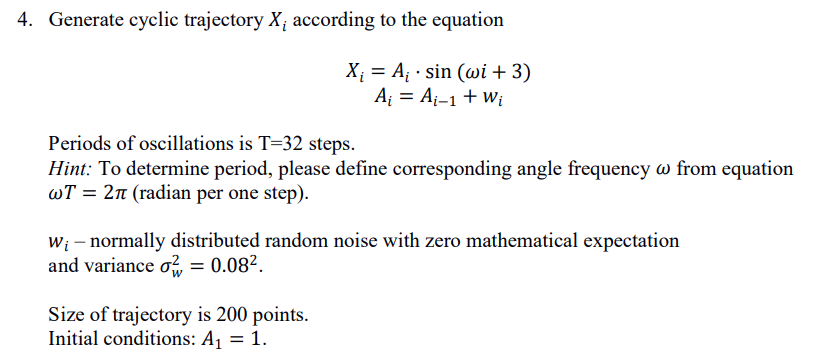

In [ ]:
size_of_trajectory = 200

X = np.zeros(size_of_trajectory)
A = np.zeros(size_of_trajectory)

# Initial conditions
A[0] = 1
T = 32

omega =  2*np.pi/T

# Variance of noise
sigma_w = 0.08**2

noise_w = np.random.normal(0, np.sqrt(sigma_w), size_of_trajectory)

for i in range(1,size_of_trajectory):
    A[i] = A[i-1] + noise_w[i]
    X[i] = A[i] * np.sin(omega*i + 3)



5. Measurement generation

In [ ]:
sigma_eta = 0.05
measurement_noise = np.random.normal(0, np.sqrt(sigma_eta), size_of_trajectory)

z = X + measurement_noise

6. Running mean applying

In [ ]:
mean_smoothing = running_mean(z, 13)

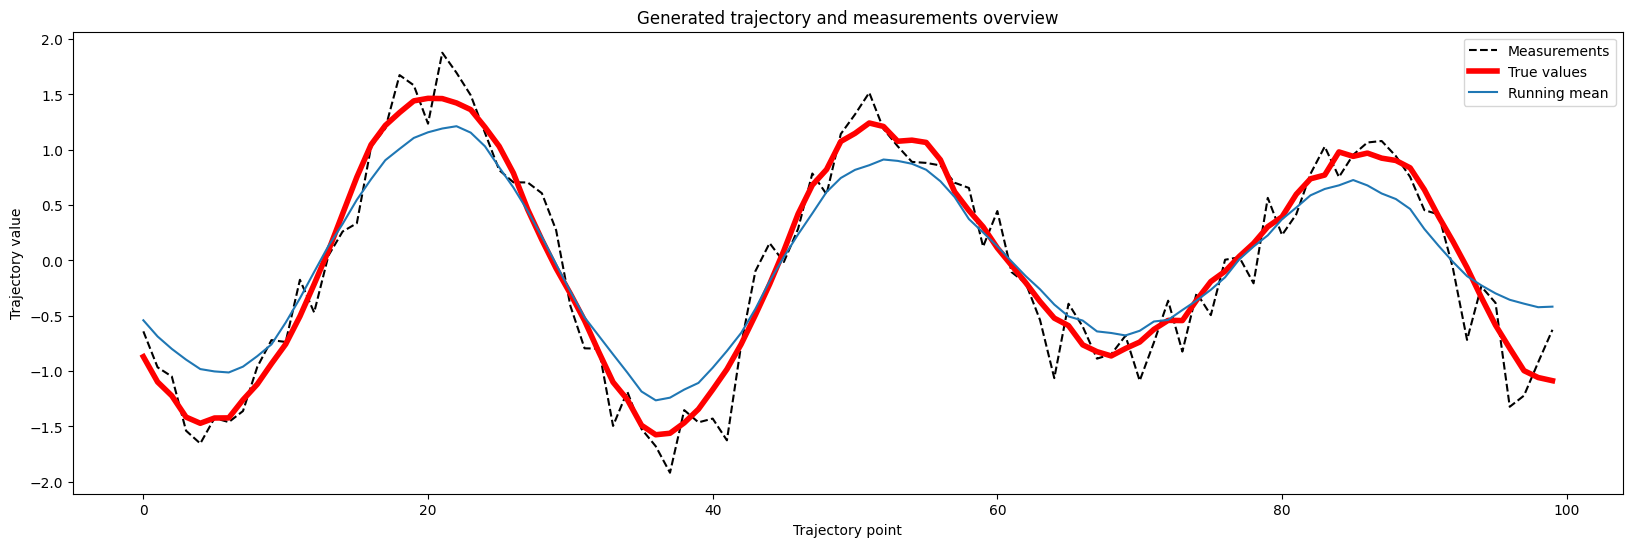

In [ ]:
plt.figure(figsize=(20, 6))
# To visually analyze the effect of smoothing, lets take only small part of data
plt.title('Generated trajectory and measurements overview')
plt.plot(z[100:], '--', color = 'black', label = 'Measurements')
plt.plot(X[100:], label = 'True values', c='red', linewidth=4)
plt.plot(mean_smoothing[100:], label = 'Running mean')
plt.ylabel('Trajectory value')
plt.xlabel('Trajectory point')
plt.legend()


As we can see running mean method with such parameters succesfully estimated the real data.

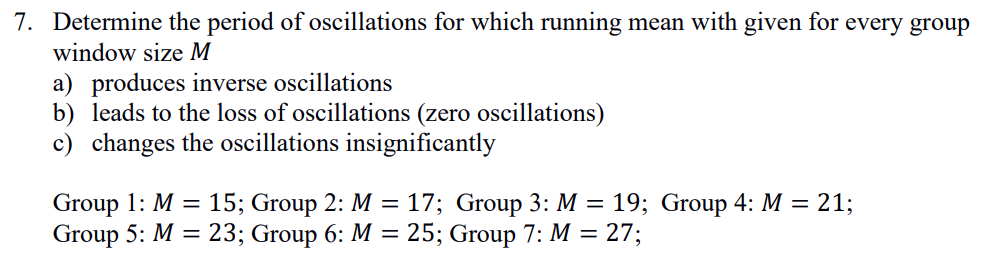

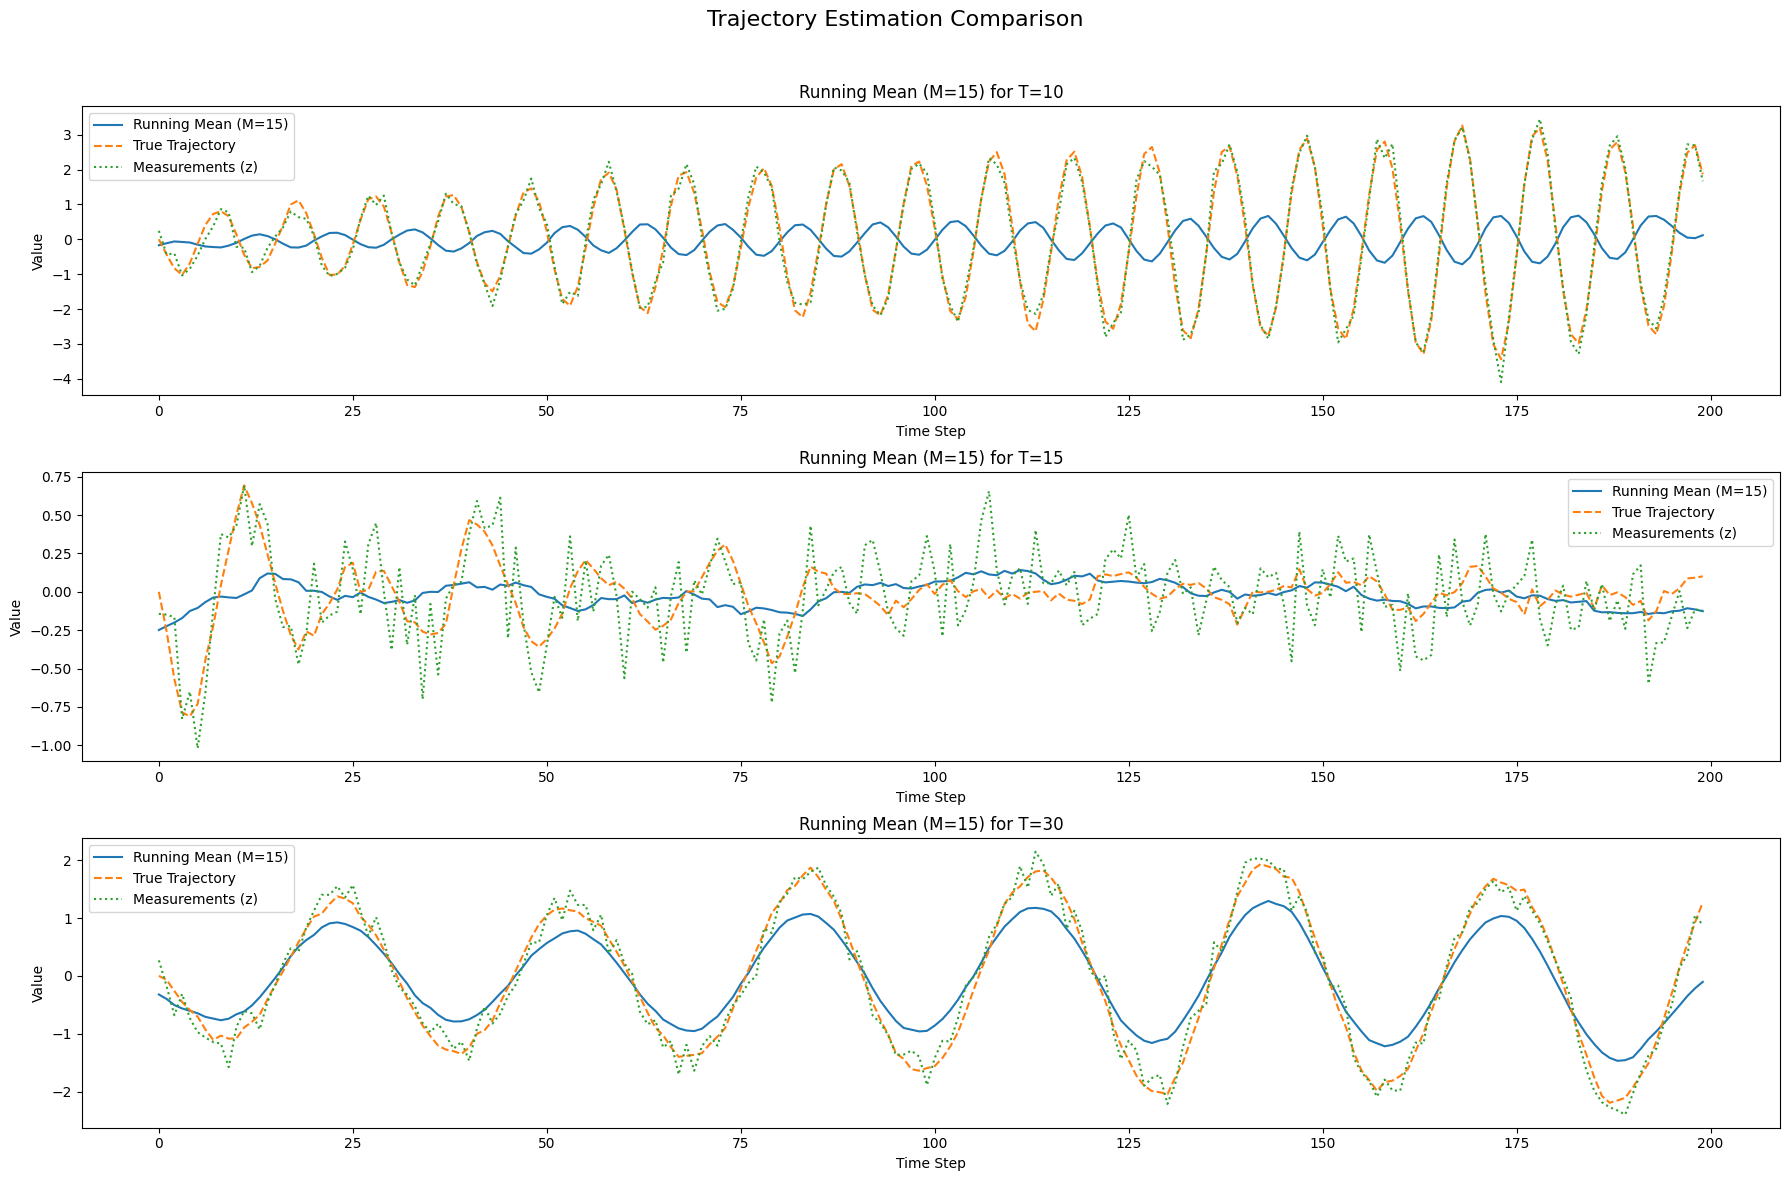

In [ ]:
size_of_trajectory = 200

X = np.zeros(size_of_trajectory)
A = np.zeros(size_of_trajectory)

# Initial conditions
A[0] = 1

# Group 1 constant M
M = 15

# T values
T_values = [10, 15, 30]

plt.figure(figsize=(18, 12))
plt.suptitle("Trajectory Estimation Comparison", fontsize=16)

for i, T in enumerate(T_values):
    omega = 2 * np.pi / T

    sigma_w = 0.08 ** 2
    noise_w = np.random.normal(0, np.sqrt(sigma_w), size_of_trajectory)

    for j in range(1, size_of_trajectory):
        A[j] = A[j - 1] + noise_w[j]
        X[j] = A[j] * np.sin(omega * j + 3)

    sigma_eta = 0.05
    measurement_noise = np.random.normal(0, np.sqrt(sigma_eta), size_of_trajectory)
    z = X + measurement_noise

    plt.subplot(3, 1, i + 1)
    smoothed = np.convolve(z, np.ones(M) / M, mode='same')
    plt.plot(smoothed, label=f"Running Mean (M={M})")
    plt.plot(X, label="True Trajectory", linestyle='--', alpha=1)
    plt.plot(z, label="Measurements (z)", linestyle=':', alpha=1)
    plt.title(f"Running Mean (M={M}) for T={T}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()


When T<M we can see, that running mean produces inverse oscillations<br>
When T=M we actually lost the oscillations<br>
When T>M the oscillations changes insignificantly thus giving us best estimation we can achieve

**Conclusion:**
In the end we practically seen that backward exponential smoothing removes the time shift and provides best estimation. We learned how to actually use and compare different methods using indicators based on our own knowledge of the measurements accuracy and our own knowledge about the process we estimate. Last thing that we seen practically is that when we approximate periodic data with running mean method we should choose window size less than the period of this periodic data/signal.